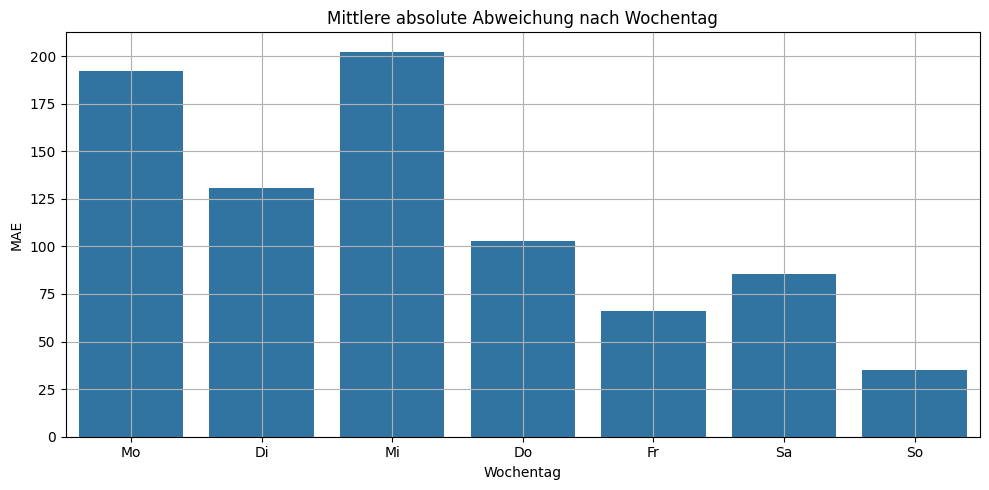

⚠️ Bedarfsklassenanalyse übersprungen: Bin edges must be unique: Index([0.0, 0.0, 1020.0], dtype='float64', name='target_true').
You can drop duplicate edges by setting the 'duplicates' kwarg


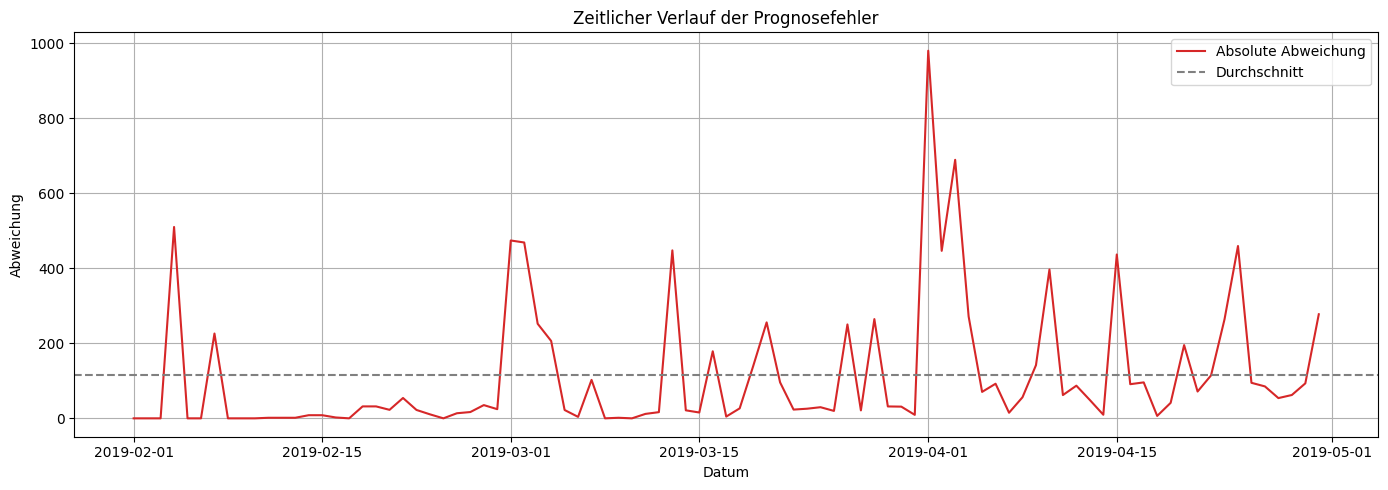

KeyError: "['is_weekend', 'is_month_start', 'is_month_end', 'holiday', 'holiday_before', 'holiday_after', 'holiday_cluster', 'holiday_on_monday_or_friday', 'holiday_density_7d'] not in index"

In [8]:
# 08_prediction_error_analysis.ipynb

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --------------------------------------
# 1. Daten laden
# --------------------------------------
pred_path = os.path.abspath("../data/predictions/lgbm_target.parquet")
df = pd.read_parquet(pred_path)

# Sicherstellen, dass Zeitstempel korrekt sind
df.index = pd.to_datetime(df.index)
df = df.asfreq("D")

# --------------------------------------
# 2. Fehlermaß berechnen (falls nicht vorhanden)
# --------------------------------------
if "abs_error" not in df.columns:
    df["abs_error"] = (df["target_pred"] - df["target_true"]).abs()

# --------------------------------------
# 3. Fehler nach Wochentagen untersuchen
# --------------------------------------
df["weekday"] = df.index.weekday
weekday_errors = df.groupby("weekday")["abs_error"].mean().reindex(range(7))

plt.figure(figsize=(10, 5))
sns.barplot(x=weekday_errors.index, y=weekday_errors.values)
plt.title("Mittlere absolute Abweichung nach Wochentag")
plt.xticks(ticks=range(7), labels=["Mo", "Di", "Mi", "Do", "Fr", "Sa", "So"])
plt.ylabel("MAE")
plt.xlabel("Wochentag")
plt.grid(True)
plt.tight_layout()
plt.show()

# --------------------------------------
# 4. Fehler nach Bedarfshöhe untersuchen
# --------------------------------------
try:
    quantiles = pd.qcut(df["target_true"], q=4, retbins=True, duplicates="drop")[1]
    n_bins = len(quantiles) - 1

    if n_bins >= 2:
        labels = ["niedrig", "mittel", "hoch", "sehr hoch"][:n_bins]
        df["bedarf_klasse"] = pd.qcut(df["target_true"], q=n_bins, labels=labels)
        bedarf_errors = df.groupby("bedarf_klasse")["abs_error"].mean()

        plt.figure(figsize=(8, 5))
        sns.barplot(x=bedarf_errors.index, y=bedarf_errors.values, palette="viridis")
        plt.title("Mittlere absolute Abweichung nach Bedarfsklasse")
        plt.ylabel("MAE")
        plt.xlabel("Bedarfsniveau")
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        print("⚠️ Zu wenige unterschiedliche Bedarfsausprägungen für eine Klasseneinteilung.")
except Exception as e:
    print(f"⚠️ Bedarfsklassenanalyse übersprungen: {e}")

# --------------------------------------
# 5. Fehler im Zeitverlauf visualisieren
# --------------------------------------
plt.figure(figsize=(14, 5))
plt.plot(df.index, df["abs_error"], label="Absolute Abweichung", color="tab:red")
plt.axhline(df["abs_error"].mean(), color="gray", linestyle="--", label="Durchschnitt")
plt.title("Zeitlicher Verlauf der Prognosefehler")
plt.ylabel("Abweichung")
plt.xlabel("Datum")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --------------------------------------
# 6. Korrelation mit erklärenden Variablen (binarisiert)
# --------------------------------------
korrelations_df = df[[
    "abs_error",
    "is_weekend", "is_month_start", "is_month_end", 
    "holiday", "holiday_before", "holiday_after",
    "holiday_cluster", "holiday_on_monday_or_friday", "holiday_density_7d"
]].copy()

correlation_matrix = korrelations_df.corr().abs()[["abs_error"]].drop("abs_error")

plt.figure(figsize=(8, 5))
sns.barplot(
    y=correlation_matrix.index,
    x=correlation_matrix["abs_error"],
    palette="coolwarm"
)
plt.xlabel("Korrelation mit Fehler (|r|)")
plt.title("Zusammenhang zwischen Fehlern und externen Faktoren")
plt.tight_layout()
plt.grid(True)
plt.show()

# --------------------------------------
# 7. Größte Ausreißer analysieren
# --------------------------------------
top_outliers = df.sort_values("abs_error", ascending=False).head(5)
print("\n🚨 Top 5 Tage mit den größten Fehlern:")
print(top_outliers[["target_true", "target_pred", "abs_error"] + [
    "weekday", "is_weekend", "is_month_start", "is_month_end",
    "holiday", "holiday_before", "holiday_after"
]].round(2))

# --------------------------------------
# 8. Ausgabe statistischer Kennzahlen
# --------------------------------------
print("\n📊 Fehlerstatistik (absolute Abweichung):")
print(df["abs_error"].describe().round(2))

print("\n🔍 Durchschnittlicher Fehler nach Bedarfsniveau:")
print(bedarf_errors.round(2))

print("\n🔍 Durchschnittlicher Fehler nach Wochentag:")
print(pd.Series(weekday_errors.values, index=["Mo", "Di", "Mi", "Do", "Fr", "Sa", "So"]).round(2))

print("\n📈 Korrelationsanalyse (|r|):")
print(correlation_matrix.round(2))


In [9]:
df.columns

Index(['target_pred', 'target_true', 'target_90_rule', 'abs_error', 'weekday'], dtype='object')